- This notebook will take the best LDA model (found to be the Mallet Model) and apply it to a training datset which will be split from the full dataset in this notebook.
- The trained model will then be applied to the test set in order to generate 'topics' for that set.

In [2]:
import pandas as pd
import numpy as np
import os
import ast

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import warnings
from PIL import Image

from sklearn.model_selection import train_test_split


import pyLDAvis
from pyLDAvis import gensim as gn 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the dataset:

- Loading the dataframe prepared in "Creating the Corpus" Jupyter Notebook:

In [3]:
beers_with_desc = pd.read_csv('Datasets/beers_w_descriptions.csv')

In [4]:
# Csv files do not recognize lists of strings well, so removing quotations and remaking the list of prepped words:
beers_with_desc.prepped_words = [ast.literal_eval(x) for x in beers_with_desc.prepped_words]

In [5]:
beers_with_desc.head()

,beer_style,abv,num_ratings,beer_style_group,prepped_words,month_added,year_added,successful
0,Altbier,4.5,542,Other,"[collaboration, magic, rock]",10,2016,No
1,Altbier,6.2,783,Other,"[beechwood, smoked, meet, double, altbier, str...",3,2014,No
2,Altbier,4.9,318,Other,"[plato, og, wylam, left, handed, giant, come, ...",7,2016,No
3,Altbier,4.5,228,Other,"[dry, hopped, altbier]",7,2016,No
4,Altbier,5.4,234,Other,"[brewdog, collabfest, last, thought, annual, f...",10,2015,No


# Building the Topic Model for the training set:

- Again using the source here: Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# To replicate the below you will need to download and unzip the following file:
# http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# Save it in a folder called 'new_mallet' in the C Drive.

In [6]:
os.environ.update({'MALLET_HOME': r'C:/new_mallet/mallet-2.0.8/'})

In [7]:
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'

## Splitting the dataframe into training and test sets:

In [8]:
X = beers_with_desc.drop(['successful'], axis=1)
y = beers_with_desc.successful

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13561, 7) (5812, 7) (13561,) (5812,)


In [10]:
X_train = X_train.reset_index(drop=True)
X_train.head(3)

,beer_style,abv,num_ratings,beer_style_group,prepped_words,month_added,year_added
0,Scottish Ale,5.2,342,Other,"[traditional, dark, amber, scottish, maltyswee...",5,2018
1,Old Ale,5.0,1088,Other,"[dark, red, fruity, chocolate]",3,2012
2,Lager - Winter,7.0,1479,Lager,"[colorado, winter, celebrated, maybe, season, ...",12,2015


## Creating corpus for the training set (using same technique used on whole dataframe):

In [11]:
train_words = X_train.prepped_words.to_list()

In [12]:
id2word_train = corpora.Dictionary(train_words)

In [13]:
corpus_train = [id2word_train.doc2bow(text) for text in train_words]

## Finding Ideal Number of Topics for Training Set:

In [20]:
# Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, random_seed = 15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
# Using function defined above:

model_list_train, coherence_values_train = compute_coherence_values(dictionary=id2word_train, corpus=corpus_train, 
                                                        texts=train_words, start=2, limit=16, step=1)

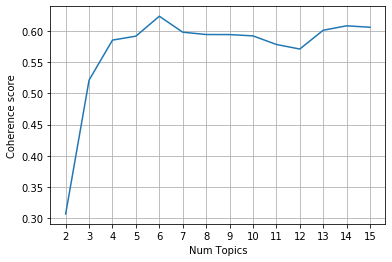

In [22]:
# Show graph of search:

limit=16; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values_train)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(x)
plt.grid('on')
plt.show()

In [35]:
max(coherence_values_train)

0.6237073263530578

- The plot above reaches  maximum coherence at 6 topics and then levels out/declines, this is similar to what we saw when we applied the model to the entire dataframe. 
- I will choose 6 topics here for the optimal model (this is at index 4 as num topics starts at 2):

In [67]:
# Specifying the opimal model from the list found above and printing out the topics and the 10 most important words in each topic.
optimal_training_model = model_list_train[4]
model_topics_train = optimal_training_model.show_topics(formatted=False)
print(optimal_training_model.print_topics(num_words=10))

[(0, '0.037*"dry" + 0.032*"fruit" + 0.026*"hopped" + 0.024*"citra" + 0.020*"tropical" + 0.020*"citrus" + 0.017*"mosaic" + 0.017*"oat" + 0.014*"double" + 0.013*"big"'), (1, '0.014*"time" + 0.014*"collaboration" + 0.010*"friend" + 0.010*"make" + 0.010*"day" + 0.009*"back" + 0.009*"good" + 0.007*"love" + 0.007*"enjoy" + 0.006*"release"'), (2, '0.054*"barrel" + 0.040*"aged" + 0.022*"bourbon" + 0.021*"oak" + 0.020*"sour" + 0.018*"fermented" + 0.014*"cider" + 0.012*"rye" + 0.012*"wine" + 0.012*"cherry"'), (3, '0.023*"bitterness" + 0.020*"full" + 0.018*"balanced" + 0.017*"orange" + 0.016*"give" + 0.013*"body" + 0.013*"sweetness" + 0.013*"bitter" + 0.013*"smooth" + 0.013*"sweet"'), (4, '0.036*"yeast" + 0.025*"light" + 0.019*"crisp" + 0.019*"refreshing" + 0.017*"belgian" + 0.016*"classic" + 0.016*"wheat" + 0.014*"clean" + 0.014*"traditional" + 0.014*"fruity"'), (5, '0.039*"coffee" + 0.039*"dark" + 0.038*"chocolate" + 0.031*"vanilla" + 0.029*"rich" + 0.018*"black" + 0.016*"roasted" + 0.015*"port

## Creating a dataframe of the training data text assigned with a topic:

In [25]:
# Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [29]:
train_topics_df = format_topics_sentences(optimal_training_model, corpus_train, train_words)

In [30]:
# Format
train_topics_df = train_topics_df.reset_index()
train_topics_df.columns = ['Description_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords_in_Topic', 'Text']
train_topics_df['Dominant_Topic'] = train_topics_df['Dominant_Topic'] + 1
train_topics_df.head()

,Description_No,Dominant_Topic,Topic_Perc_Contrib,Keywords_in_Topic,Text
0,0,4.0,0.2573,"bitterness, full, balanced, orange, give, body...","[traditional, dark, amber, scottish, maltyswee..."
1,1,6.0,0.1914,"coffee, dark, chocolate, vanilla, rich, black,...","[dark, red, fruity, chocolate]"
2,2,2.0,0.2352,"time, collaboration, friend, make, day, back, ...","[colorado, winter, celebrated, maybe, season, ..."
3,3,1.0,0.2444,"dry, fruit, hopped, citra, tropical, citrus, m...","[bouncer, usually, stop, door, shoe, guy, musc..."
4,4,6.0,0.1988,"coffee, dark, chocolate, vanilla, rich, black,...","[tribute, classic, golden, gaytime, ice, cream..."


# Visualizing the training data topics spread:

In [31]:
def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, 
                            alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [32]:
# Converting first to feed into viz tool:
converted_model_train = ldaMalletConvertToldaGen(optimal_training_model)

In [33]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(converted_model_train, corpus_train, id2word_train, sort_topics=False)
vis

C:\Users\rozhouse\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\rozhouse\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\rozhouse\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\rozhouse\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.142208  0.262235       1        1  16.669699
1     -0.307803  0.010054       2        1  17.786531
2     -0.239628 -0.122308       3        1  16.385662
3      0.191612 -0.127440       4        1  16.634521
4      0.037074  0.251729       5        1  16.339272
5      0.176538 -0.274270       6        1  16.184320, topic_info=    Category         Freq       Term        Total  loglift  logprob
288  Default  2757.000000     barrel  2757.000000  30.0000  30.0000
287  Default  2056.000000       aged  2056.000000  29.0000  29.0000
303  Default  1948.000000     coffee  1948.000000  28.0000  28.0000
5    Default  1943.000000       dark  1943.000000  27.0000  27.0000
26   Default  1911.000000  chocolate  1911.000000  26.0000  26.0000
..       ...          ...        ...          ...      ...      ...
50    Topic6   711.534607      sweet  1360.675537   1.1728  -4.2558
48    Topic6   567.071533     smooth  1231.460693   1.0457  -4.4828
342   Topic6   484.059143    caramel   960.023193   1.1364  -4.6410
593   Topic6   425.842651    complex   793.979614   1.1981  -4.7692
133   Topic6   378.407043      added   711.139404   1.1902  -4.8873

[447 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
6991       1  0.950353  accentuating
1570       5  0.986762       achieve
133        1  0.195461         added
133        3  0.272802         added
133        6  0.531541         added
...      ...       ...           ...
1929       2  0.999387          work
403        2  0.611709         world
403        5  0.387599         world
12210      1  0.950353       ximenez
223        5  1.000070         yeast

[482 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [34]:
pyLDAvis.save_html(vis, 'Figures/lda_topic_graph_6_topics_training_data.html')

## Combining the topics training df with the training data:

In [42]:
# Combining the two dataframes:

training_topics = pd.concat([X_train, train_topics_df], axis=1)

In [44]:
# Dropping unneccesary columns:
training_topics.drop(['Description_No', 'Keywords_in_Topic', 'Text'], axis=1, inplace=True)

In [46]:
# Saving this for chart creation in another notebook:
training_topics.to_csv('Datasets/train_topics_w_words.csv')

In [47]:
training_topics.drop(['prepped_words'], axis=1, inplace=True)

In [48]:
training_topics.head(3)

,beer_style,abv,num_ratings,beer_style_group,month_added,year_added,Dominant_Topic,Topic_Perc_Contrib
0,Scottish Ale,5.2,342,Other,5,2018,4.0,0.2573
1,Old Ale,5.0,1088,Other,3,2012,6.0,0.1914
2,Lager - Winter,7.0,1479,Lager,12,2015,2.0,0.2352


# Applying the model to X_test to predict the dominant topic for each row:

- This replicates applying the topic model to new, unseen data in the future, for example the beers from 2021 next year.

In [49]:
optimal_training_model

In [50]:
X_test = X_test.reset_index(drop=True)
X_test.head(3)

,beer_style,abv,num_ratings,beer_style_group,prepped_words,month_added,year_added
0,Grätzer / Grodziskie,4.8,423,Other,"[traditional, polish, oaksmoked, wheat, york, ...",2,2014
1,IPA - Imperial / Double Black,10.0,713,IPA,"[bridge, road, turned, celebrate, occasion, mu...",1,2016
2,Gruit / Ancient Herbed Ale,4.9,151,Other,"[awesome, tumeric, flavored, gruit]",5,2016


In [51]:
# Making a list of the words from the test set:
test_words = X_test.prepped_words.to_list()

In [52]:
# Creating a corpora dictionary with each word associated with an id
id2word_test = corpora.Dictionary(test_words)

In [53]:
# Creating the corpus for the model to use
corpus_test = [id2word_train.doc2bow(text) for text in test_words]

In [54]:
# Applying the LDA model that was built on the training data to the test corpus:
test_topics_df = format_topics_sentences(optimal_training_model, corpus_test, test_words)

In [55]:
# Formatting
test_topics_df = test_topics_df.reset_index()
test_topics_df.columns = ['Description_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords_in_Topic', 'Text']
test_topics_df['Dominant_Topic'] = test_topics_df['Dominant_Topic'] + 1
test_topics_df.head(10)

,Description_No,Dominant_Topic,Topic_Perc_Contrib,Keywords_in_Topic,Text
0,0,5.0,0.2496,"yeast, light, crisp, refreshing, belgian, clas...","[traditional, polish, oaksmoked, wheat, york, ..."
1,1,2.0,0.2529,"time, collaboration, friend, make, day, back, ...","[bridge, road, turned, celebrate, occasion, mu..."
2,2,4.0,0.1893,"bitterness, full, balanced, orange, give, body...","[awesome, tumeric, flavored, gruit]"
3,3,6.0,0.2549,"coffee, dark, chocolate, vanilla, rich, black,...","[interred, baltic, porter, archipelago, fresh,..."
4,4,6.0,0.2616,"coffee, dark, chocolate, vanilla, rich, black,...","[whey, inspired, medicinal, milk, victorian, e..."
5,5,1.0,0.1852,"dry, fruit, hopped, citra, tropical, citrus, m...","[fruit, wine, nectarine, pineappl]"
6,6,4.0,0.2015,"bitterness, full, balanced, orange, give, body...","[strong, english, complex, toffee, roast, good..."
7,7,3.0,0.3786,"barrel, aged, bourbon, oak, sour, fermented, c...","[st, florence, australian, wild, refermented, ..."
8,8,3.0,0.2616,"barrel, aged, bourbon, oak, sour, fermented, c...","[wine, barrel, aged, golden, fermented, mixed,..."
9,9,5.0,0.2149,"yeast, light, crisp, refreshing, belgian, clas...","[ustic, reinvented, remembered, using, yeast, ..."


In [58]:
# Combining the two dataframes:
test_topics = pd.concat([X_test, test_topics_df], axis=1)

In [60]:
# Dropping unneccesary columns:
test_topics.drop(['Description_No', 'Keywords_in_Topic', 'Text'], axis=1, inplace=True)

In [61]:
# Saving this for chart creation in another notebook:
test_topics.to_csv('Datasets/test_topics_w_words.csv')

In [62]:
test_topics.drop(['prepped_words'], axis=1, inplace=True)

In [63]:
test_topics.head(3)

,beer_style,abv,num_ratings,beer_style_group,month_added,year_added,Dominant_Topic,Topic_Perc_Contrib
0,Grätzer / Grodziskie,4.8,423,Other,2,2014,5.0,0.2496
1,IPA - Imperial / Double Black,10.0,713,IPA,1,2016,2.0,0.2529
2,Gruit / Ancient Herbed Ale,4.9,151,Other,5,2016,4.0,0.1893


# Saving test and training sets to use in the model:

In [64]:
training_topics.to_csv('Datasets/X_train.csv', index= False, header=True)
test_topics.to_csv('Datasets/X_test.csv', index= False, header=True)
y_train.to_csv('Datasets/y_train.csv', index= False, header=True)
y_test.to_csv('Datasets/y_test.csv', index= False, header=True)